#LAB 8 : Classification

  1. Support Vector Machines 
  2. K-Nearest Neighbors
  3. Classification on MNIST Digit 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from jupyterthemes import jtplot
jtplot.style(theme = "monokai",context = "notebook", ticks = True,grid = False)

#Support Vector Machines (SVM)



1. Try to maximize the margin of separation between data.
2. Instead of learning wx+b=0  separating hyperplane directly (like logistic regression), SVM try to learn wx+b=0, such that, the margin between two hyperplanes wx+b=1 and wx+b=-1 (also known as support vectors) is maximum. 
3. Margin between wx+b=1 and wx+b=-1 hyperplane is $\frac{2}{||w||}$
4. we have a constraint optimization problem of maximizing $\frac{2}{||w||}$, with constraints wx+b>=1 (for +ve class) and wx+b<=-1 (for -ve class).
5. As $y_{i}=1$ for +ve class and $y_{i}=-1$ for -ve class, the constraint can be re-written as:
$$y(wx+b)>=1$$

6. Final optimization is (i.e to find w and b):
$$\min_{||w||}\frac{1}{2}||w||,$$
$$y(wx+b) \geq 1,~\forall ~data $$



Acknowledgement:

https://pythonprogramming.net/predictions-svm-machine-learning-tutorial/

https://medium.com/deep-math-machine-learning-ai/chapter-3-1-svm-from-scratch-in-python-86f93f853dc

## Data generation:
1. Generate 2D gaussian data with fixed mean and variance for 2 class.(var=Identity, class1: mean[-4,-4], class2: mean[1,1], No. of data 25 from each class)
2. create the label matrix
3. Plot the generated data

(50, 2)
(50,)


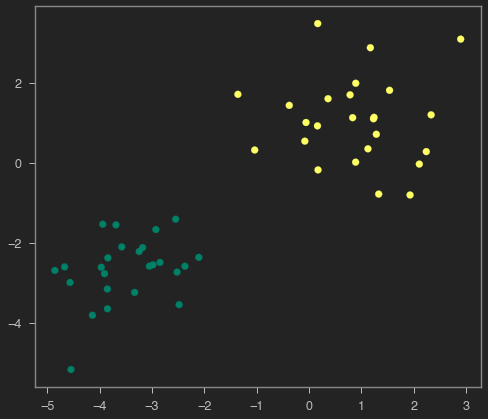

In [2]:
No_sample=50
mean1=np.array([-3,-3])
var1=np.array([[1,0],[0,1]])
mean2=np.array([1,1])
var2=var1
data1=np.random.multivariate_normal(mean1,var1,int(No_sample/2))
data2=np.random.multivariate_normal(mean2,var2,int(No_sample/2))
X=np.concatenate((data1,data2))
print(X.shape)
y=np.concatenate((-1*np.ones(data1.shape[0]),np.ones(data2.shape[0])))
#y = y[:,np.newaxis]
print(y.shape)

plt.figure()
plt.scatter(X[:,0],X[:,1],marker='o',c=y,cmap='summer')

Create a data dictionary, which contains both label and data points.

In [3]:
positiveX=[]
negativeX=[]
# Write your code here
positiveX = X[np.where(y==1)]
negativeX = X[np.where(y==-1)]

#our data dictionary|
data_dict = {-1:np.array(negativeX), 1:np.array(positiveX)} 
#print(data_dict[-1])
max_feature_value=float('-inf')
min_feature_value=float('+inf')
        
for yi in data_dict:
    if np.amax(data_dict[yi])>max_feature_value:
        max_feature_value=np.amax(data_dict[yi])
                
    if np.amin(data_dict[yi])<min_feature_value:
        min_feature_value=np.amin(data_dict[yi])
#print(min_feature_value)
# print(data_dict)
learning_rate = [max_feature_value * 0.1, max_feature_value * 0.01]

## SVM training
1. create a search space for w (i.e w1=w2),[0, 0.5*max((abs(feat)))] and  for b, [-max((abs(feat))),max((abs(feat)))], with appropriate step.
2. we will start with a higher step and find optimal w and b, then we will reduce the step and again re-evaluate the optimal one.

3. In each step, we will take transform of w, [1,1], [-1,1],[1,-1] and [-1,-1] to search arround the w. 

4. In every pass (for a fixed step size) we will store all the w, b and its corresponding ||w||, which make the data correctly classified as per the condition $y(wx+b) \geq 1$. 

5. Obtain the optimal hyperplane having minimum ||w||.

6. Start with the optimal w and repeat the same (step 3,4 and 5) for a reduced step size.


In [4]:
# it is just a searching algorithem, not a complicated optimization algorithem, (just for understanding of concepts through visualization)

def SVM_Training(data_dict):
    # insert your code here
    global w
    global b
    # { ||w||: [w,b] }
    length_Wvector = {}
    transforms = [[1,1],[-1,1],[-1,-1],[1,-1]]
    
    b_step_size = 2
    b_multiple = 5
    w_optimum = max_feature_value*0.5

    for lrate in learning_rate:
        
        w = np.array([w_optimum,w_optimum])     
        optimized = False
        while not optimized:
            #b=[-maxvalue to maxvalue] we wanna maximize the b values so check for every b value
            for b in np.arange(-1*(max_feature_value*b_step_size), max_feature_value*b_step_size, lrate*b_multiple):
                for transformation in transforms:  # transforms = [[1,1],[-1,1],[-1,-1],[1,-1]]
                    w_t = w*transformation
                    
                    correctly_classified = True
                    
                    # every data point should be correct
                    for yi in data_dict:
                        for xi in data_dict[yi]:
                            if yi*(np.dot(w_t,xi)+b) < 1:  # we want  yi*(np.dot(w_t,xi)+b) >= 1 for correct classification
                                correctly_classified = False
                                
                    if correctly_classified:
                        length_Wvector[np.linalg.norm(w_t)] = [w_t,b] #store w, b for minimum magnitude
            if w[0] < 0:
                optimized = True
            else:
                w = w - lrate

        norms = sorted([n for n in length_Wvector])
        
        minimum_wlength = length_Wvector[norms[0]]
        w = minimum_wlength[0]
        b = minimum_wlength[1]
        
        w_optimum = w[0]+lrate*2
    return(w,b)

**Training**

In [5]:
# All the required variables 
w=[] # Weights 2 dimensional vector
b=[] # Bias
w,b=SVM_Training(data_dict)
print(w)
print(b)

[0.66217443 0.66217443]
1.5683078633407428


## Visualization of the SVM separating hyperplanes (after training)

In [6]:
def visualize(data_dict):
    plt.scatter(X[:,0],X[:,1],marker='o',c=y,cmap='summer')
    # hyperplane = x.w+b
    # v = x.w+b
    # psv = 1
    # nsv = -1
    # dec = 0
    def hyperplane_value(x,w,b,v): return (-w[0]*x-b+v) / w[1]
    hyp_x_min = np.min([np.min(data_dict[1]),np.min(data_dict[-1])]) 
    hyp_x_max = np.max([np.max(data_dict[1]),np.max(data_dict[-1])])
    # (w.x+b) = 1
    # positive support vector hyperplane
    psv1 = hyperplane_value(hyp_x_min, w, b, 1) 
    psv2 = hyperplane_value(hyp_x_max, w, b, 1) 
    plt.plot([hyp_x_min,hyp_x_max],[psv1,psv2], 'lightsteelblue')
    # (w.x+b) = -1
    # negative support vector hyperplane
    nsv1 = hyperplane_value(hyp_x_min, w, b, -1) 
    nsv2 = hyperplane_value(hyp_x_max, w, b, -1) 
    plt.plot([hyp_x_min,hyp_x_max],[nsv1,nsv2], 'lightsteelblue')
    # (w.x+b) = 0
    # positive support vector hyperplane
    db1 = hyperplane_value(hyp_x_min, w, b, 0)
    db2 = hyperplane_value(hyp_x_max, w, b, 0) 
    plt.plot([hyp_x_min,hyp_x_max],[db1,db2], 'y--')
        
        
        

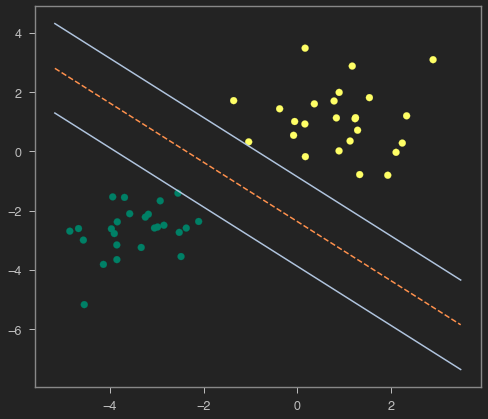

In [7]:
fig = plt.figure()
visualize(data_dict)

**Testing**

In [8]:
def predict(data,w,b):
    # sign( x.w+b )
    pred = np.sign(np.dot(data,w)+b).astype(int)
    return pred

Test accuracy= 100.0


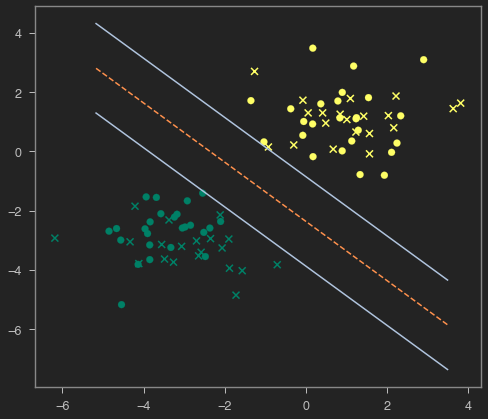

In [9]:
No_test_sample=40
data1=np.random.multivariate_normal(mean1,var1,int(No_test_sample/2))
data2=np.random.multivariate_normal(mean2,var2,int(No_test_sample/2))
test_data=np.concatenate((data1,data2))
y_gr=np.concatenate((-1*np.ones(data1.shape[0]),1*np.ones(data2.shape[0])))

# evaluate with the trained model

y_pred = predict(test_data,w,b)
accuracy = 100*np.sum(y_gr==y_pred)/No_test_sample# Write your code here
print('Test accuracy=',accuracy)
#  Visualization
plt.figure()
visualize(data_dict)
plt.scatter(test_data[:,0],test_data[:,1],marker='x',c=y_pred,cmap='summer')


**Use the Sci-kit Learn Package and perform Classification on the above dataset using the SVM algorithm**

Test accuracy= 100.0


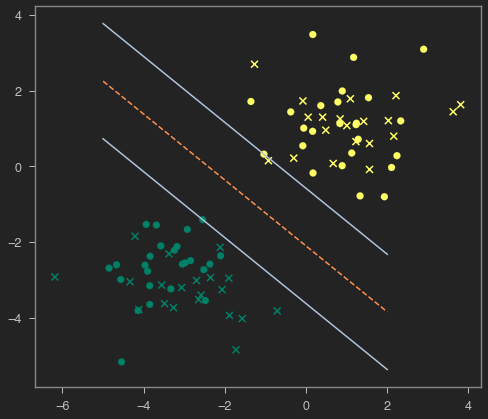

In [10]:
## Write your code here
from sklearn.svm import SVC

model = SVC(kernel="linear").fit(X, y)
# Plot the line
w = model.coef_[0]

# Because w was the weight for each feature
# We should convert it to the slope
a = -w[0] / w[1]

xx = np.linspace(-5, 2, 1200)
yy = a * xx - model.intercept_[0] / w[1]

# Plot the support vector
support_vectors = model.support_vectors_

y_pred = model.predict(test_data)
accuracy = 100*np.sum(y_gr==y_pred)/No_test_sample# Write your code here
print('Test accuracy=',accuracy)

# Plot the line through support vector
yy_1 = a * xx - (model.intercept_[0] - 1) / w[1]
yy_2 = a * xx - (model.intercept_[0] + 1) / w[1]

plt.plot(xx, yy_1, 'lightsteelblue')
plt.plot(xx, yy_2, 'lightsteelblue')


plt.plot(xx, yy,'y--')
plt.scatter(X[:,0],X[:,1],c=y,cmap='summer')
plt.scatter(test_data[:,0],test_data[:,1],marker='x',c=y_pred,cmap='summer')

#K-Nearest Neighbours (KNN)

Text(0.5, 1.0, 'Data visualization')

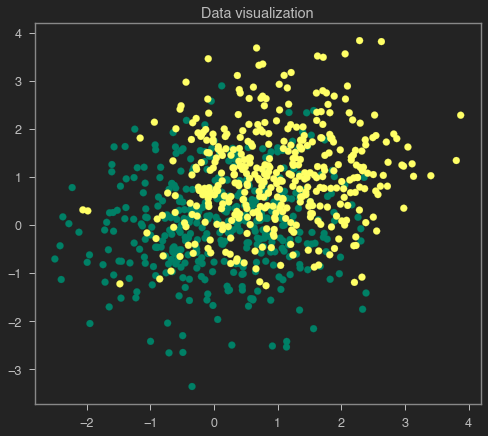

In [11]:
import numpy as np
import matplotlib.pyplot as plt

mean1=np.array([0,0])
mean2=np.array([1,1])
var=np.array([[1,0.1],[0.1,1]])
np.random.seed(0)
data1=np.random.multivariate_normal(mean1,var,500)
data2=np.random.multivariate_normal(mean2,var,500)
data_train=np.concatenate((data1[:-100,],data2[:-100]))
label=np.concatenate((np.zeros(data1.shape[0]-100),np.ones(data2.shape[0]-100)))

plt.figure()
plt.scatter(data_train[:,0],data_train[:,1],c=label,cmap='summer')
plt.title('Data visualization')

In [12]:
def euclidean_distance(row1, row2):
    return np.linalg.norm(row1-row2)

In [13]:
def get_neighbors(train,label_train, test_row, num_neighbors):
  ## write your code here
    distances = []
    for x in range(train.shape[0]):
        dist = euclidean_distance(test_row, train[x])
        distances.append(dist)
    #print(distances)
    neighbors = []
    for x in range(num_neighbors):
    #find minimum distance
        index = distances.index(min(distances))
        neighbors.append(label[index])
        distances[index] = max(distances)
    #print(neighbors)
    return neighbors


In [14]:
def predict_classification(neigbors):
  ## write your code here
    if(neigbors[0] == 1 and neigbors[1] == 1):
        prediction = 1
    elif(neigbors[0] == 0 and neigbors[1] == 0):
        prediction = 0
    elif(neigbors[0] == 1 and neigbors[1] == 0):
        prediction = 1
    elif(neigbors[0] == 0 and neigbors[1] == 1):
        prediction = 0
    else:
        prediction = 0
    #print(prediction)
    return prediction


In [15]:
# test data generation
data_test=np.concatenate((data1[-100:],data2[-100:]))
label_test=np.concatenate((np.zeros(100),np.ones(100)))

Testing Accuracy= 66.0 %


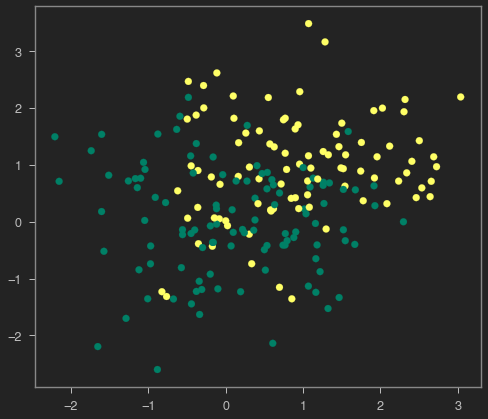

In [16]:
K=2

pred_label=np.zeros(data_test.shape[0])
for i in range(data_test.shape[0]):
    neig=get_neighbors(data_train,label, data_test[i,:], K)
    pred_label[i]=predict_classification(neig)

accuracy=(len(np.where(pred_label==label_test)[0])/len(label_test))*100
plt.scatter(data_test[:,0],data_test[:,1],c=pred_label,cmap='summer')
print('Testing Accuracy=',accuracy,'%')

**Use the Sci-kit Learn Package and perform Classification on the above dataset using the K-Nearest Neighbour algorithm**

Testing Accuracy= 66.0 %


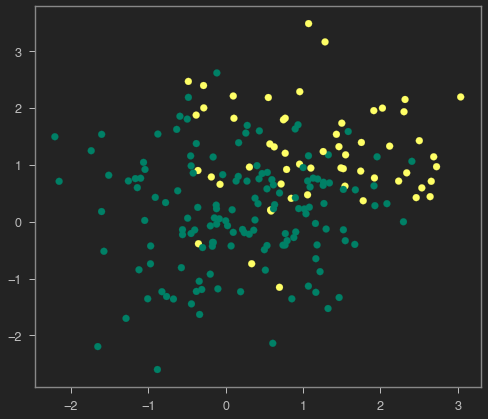

In [17]:
## Write your code here
from sklearn.neighbors import KNeighborsClassifier as KNN

model = KNN(n_neighbors=2)
model.fit(data_train,label);
pred= model.predict(data_test)

accuracy=(len(np.where(pred_label==label_test)[0])/len(label_test))*100
print('Testing Accuracy=',accuracy,'%')

plt.scatter(data_test[:,0],data_test[:,1],c=pred,cmap='summer')


#Classification on MNIST Digit Data

1. Read MNIST data and perform train-test split
2. Select any 2 Classes and perform classification task using SVM, KNN and Logistic Regression algorithms with the help of Sci-Kit Learn tool
3. Report the train and test accuracy and also display the results using confusion matrix
4. Repeat steps 2 and 3 for all 10 Classes and tabulate the results

In [25]:
## Write your code here
import idx2numpy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

img_path = '/Users/kushagrakhatwani/Downloads/t10k-images-idx3-ubyte (1)'
label_path = '/Users/kushagrakhatwani/Downloads/t10k-labels-idx1-ubyte (1)'

data= idx2numpy.convert_from_file(img_path)
labels= idx2numpy.convert_from_file(label_path)

data = np.reshape(data , (data.shape[0],-1))
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.10, random_state=42)

#KNN
print("Model KNN:")
model = KNN(n_neighbors=10)
#model fit on train data
model.fit(data_train,labels_train);
#prediction on train data
pred_tr = model.predict(data_train)
#prediction on test data
pred= model.predict(data_test)

#Accuracy Metrics
cm = confusion_matrix(labels_train, pred_tr)
acc = accuracy_score(labels_train, pred_tr)
print("Train Metrics:")
print('Train_Accuracy:',acc*100)
print('Confusion Matrix:\n',cm)

cm = confusion_matrix(labels_test, pred)
acc = accuracy_score(labels_test, pred)
print("Test Metrics:")
print('Test_Accuracy:',acc*100)
print('Confusion Matrix:\n',cm)


Model KNN:
Train Metrics:
Train_Accuracy: 95.62222222222222
Confusion Matrix:
 [[ 864    1    0    0    0    4    4    1    0    0]
 [   0 1017    2    2    0    0    1    0    0    0]
 [  14   28  864    4    1    0    2   16    5    0]
 [   0    4    1  874    0    5    0    8    3    3]
 [   0   17    0    0  824    0    3    0    1   22]
 [   4    8    1   19    1  768   10    1    0    2]
 [   5    6    0    0    2    1  858    0    0    0]
 [   0   37    1    0    2    1    0  894    0   10]
 [   5   10    4   20    7   20    2   10  794    5]
 [   4    9    3    4    8    1    1   15    3  849]]
Test Metrics:
Test_Accuracy: 93.4
Confusion Matrix:
 [[103   0   0   0   0   0   3   0   0   0]
 [  0 113   0   0   0   0   0   0   0   0]
 [  2   3  84   0   0   0   2   6   1   0]
 [  0   0   1 108   0   1   0   2   0   0]
 [  0   0   0   0 107   0   2   1   0   5]
 [  0   1   0   3   1  71   0   0   0   2]
 [  3   0   0   0   1   0  82   0   0   0]
 [  0   3   0   0   0   0   0  80   

In [19]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
print("Model Logistic Regression:")
logisticRegr = LogisticRegression(max_iter=1000)
scaler = preprocessing.StandardScaler().fit(data_train)
data_s = scaler.transform(data_train)
data_ts = scaler.transform(data_test)
#model fit on data
logisticRegr.fit(data_s, labels_train)
#predition on test data
pred = logisticRegr.predict(data_ts)
#prediction on train data
pred_tr = logisticRegr.predict(data_s)

#Accuracy metrics
cm = confusion_matrix(labels_train, pred_tr)
acc = accuracy_score(labels_train, pred_tr)
print("Train Metrics:")
print('Train_Accuracy:',acc*100)
print('Confusion Matrix:\n',cm)

cm = confusion_matrix(labels_test, pred)
acc = accuracy_score(labels_test, pred)
print("Test Metrics:")
print('Test_Accuracy:',acc*100)
print('Confusion Matrix:\n',cm)

Model Logistic Regression:
Train Metrics:
Train_Accuracy: 99.96666666666667
Confusion Matrix:
 [[ 874    0    0    0    0    0    0    0    0    0]
 [   0 1022    0    0    0    0    0    0    0    0]
 [   0    0  934    0    0    0    0    0    0    0]
 [   0    0    0  898    0    0    0    0    0    0]
 [   0    0    0    0  867    0    0    0    0    0]
 [   0    0    0    0    0  814    0    0    0    0]
 [   0    0    0    0    0    0  872    0    0    0]
 [   0    0    0    0    0    0    0  944    0    1]
 [   0    0    0    1    0    0    0    0  876    0]
 [   0    0    0    1    0    0    0    0    0  896]]
Test Metrics:
Test_Accuracy: 90.3
Confusion Matrix:
 [[102   0   1   1   0   0   2   0   0   0]
 [  0 108   0   0   1   0   1   1   2   0]
 [  1   1  87   0   1   1   1   3   3   0]
 [  0   0   3 100   0   8   0   1   0   0]
 [  0   0   3   0 103   0   4   1   0   4]
 [  0   1   0   2   1  69   2   0   2   1]
 [  3   0   0   0   2   2  79   0   0   0]
 [  1   0   0   2   

In [20]:
#SVM
from sklearn.svm import SVC

print("Model SVM:")
#model fit on train data
model = SVC(kernel="linear").fit(data_train, labels_train)
#prediction on test data
pred = model.predict(data_test)
#prediction on train data
pred_tr = model.predict(data_train)

#Accuracy Metrics
cm = confusion_matrix(labels_train, pred_tr)
acc = accuracy_score(labels_train, pred_tr)
print("Train Metrics:")
print('Train_Accuracy:',acc*100)
print('Confusion Matrix:\n',cm)

cm = confusion_matrix(labels_test, pred)
acc = accuracy_score(labels_test, pred)
print("Test Metrics:")
print('Test_Accuracy:',acc*100)
print('Confusion Matrix:\n',cm)

Model SVM:
Train Metrics:
Train_Accuracy: 100.0
Confusion Matrix:
 [[ 874    0    0    0    0    0    0    0    0    0]
 [   0 1022    0    0    0    0    0    0    0    0]
 [   0    0  934    0    0    0    0    0    0    0]
 [   0    0    0  898    0    0    0    0    0    0]
 [   0    0    0    0  867    0    0    0    0    0]
 [   0    0    0    0    0  814    0    0    0    0]
 [   0    0    0    0    0    0  872    0    0    0]
 [   0    0    0    0    0    0    0  945    0    0]
 [   0    0    0    0    0    0    0    0  877    0]
 [   0    0    0    0    0    0    0    0    0  897]]
Test Metrics:
Test_Accuracy: 92.4
Confusion Matrix:
 [[104   0   0   1   0   1   0   0   0   0]
 [  0 111   0   0   0   0   1   0   1   0]
 [  1   0  91   0   1   0   1   3   1   0]
 [  0   1   3  99   0   7   0   2   0   0]
 [  0   0   2   0 107   0   2   0   0   4]
 [  1   1   0   2   1  70   1   0   1   1]
 [  2   0   0   0   1   1  81   0   1   0]
 [  1   0   3   0   1   0   0  78   0   0]
 [  0

**Note : If you are interested, also try classifying MNIST digit data using the code you have written for SVM, KNN and Logistic Regression** 

  